<a href="https://colab.research.google.com/github/RandyV37/Telecom-X-part-2-Data-Science-/blob/main/TelecomX(Challenge_parte_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importar librerias y cargar mi dataset

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import NearMiss
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold


df = pd.read_csv('TelecomX_Data_Tratada.csv')


## Ubicar Variables categoricas

In [33]:
Variables_Categoricas = df.select_dtypes(include=['object']).columns.tolist()

## Encoding

In [34]:
encoder = OneHotEncoder(
    drop='first',
    sparse_output=False,
    handle_unknown='ignore'
)

Array_codificado = encoder.fit_transform(df[Variables_Categoricas])
Variables_categoricas_codificadas = encoder.get_feature_names_out(Variables_Categoricas)
df_x_codificada = pd.DataFrame(Array_codificado, columns=Variables_categoricas_codificadas, index=df.index)
variables_numericas = df.drop(columns=Variables_Categoricas)
Df_final = pd.concat([variables_numericas, df_x_codificada], axis=1)

In [35]:
Df_final.value_counts(subset="Cliente_Detractor")

,count
Cliente_Detractor,
0,5398
1,1869


## Dividir base de datos entre entrenamiento y prueba

In [155]:
X = Df_final.drop(columns=['Cliente_Detractor'])  # Adjust if your target column is named differently
y = Df_final['Cliente_Detractor']

# Split the dataset
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_index, test_index in kf.split(X):
    print(f"\n--- Fold {fold} ---")

    # Split the data
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    print(f"Training size: {X_train_fold.shape[0]}, Test size: {X_test_fold.shape[0]}")
    fold += 1


--- Fold 1 ---
Training size: 5813, Test size: 1454

--- Fold 2 ---
Training size: 5813, Test size: 1454

--- Fold 3 ---
Training size: 5814, Test size: 1453

--- Fold 4 ---
Training size: 5814, Test size: 1453

--- Fold 5 ---
Training size: 5814, Test size: 1453


## Balanceo de clases

### Undersampling

In [156]:
# Combine train features and labels
train_combined = pd.concat([X_train_fold, y_train_fold], axis=1)

# Split by class
train_majority = train_combined[train_combined.Cliente_Detractor == 0]
train_minority = train_combined[train_combined.Cliente_Detractor == 1]

# Downsample majority
train_majority_downsampled = resample(
    train_majority,
    replace=False,
    n_samples=len(train_minority),
    random_state=42
)

# Combine balanced train set
train_balanced = pd.concat([train_majority_downsampled, train_minority])
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate X and y again
X_train_bal = train_balanced.drop(columns=['Cliente_Detractor'])
y_train_bal = train_balanced['Cliente_Detractor']

In [161]:
print("Before Undersample:", Counter(y_train_fold))
print("After Undersample:", Counter(y_train_bal))

Before Undersample: Counter({0: 4312, 1: 1502})
After Undersample: Counter({0: 1502, 1: 1502})


### Oversampling

In [158]:
# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply to training set
X_train_Oversample, y_train_Oversample = smote.fit_resample(X_train_fold, y_train_fold)

In [159]:
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_Oversample))

Before SMOTE: Counter({0: 3778, 1: 1308})
After SMOTE: Counter({0: 4312, 1: 4312})


## Modelo de Regresión

In [170]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_nm, y_train_nm)
# Apply NearMiss on training data only
nm = NearMiss(version=3)
X_train_nm, y_train_nm = nm.fit_resample(X_train_fold, y_train_fold)

In [171]:
y_pred = knn_model.predict(X_test_fold)

In [172]:
# Accuracy
accuracy = accuracy_score(y_test_fold, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification report
print("Classification Report:")
print(classification_report(y_test_fold, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_fold, y_pred))

Accuracy: 0.7034
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1086
           1       0.44      0.59      0.50       367

    accuracy                           0.70      1453
   macro avg       0.64      0.67      0.65      1453
weighted avg       0.74      0.70      0.72      1453

Confusion Matrix:
[[804 282]
 [149 218]]


In [169]:
knn_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=10))
])

knn_pipeline.fit(X_train_fold, y_train_fold)

# Predict and evaluate
y_pred = knn_pipeline.predict(X_test_fold)

print(f'Accuracy: {accuracy_score(y_test_fold, y_pred):.4f}')
print(classification_report(y_test_fold, y_pred))

Accuracy: 0.7784
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1086
           1       0.60      0.38      0.46       367

    accuracy                           0.78      1453
   macro avg       0.70      0.65      0.66      1453
weighted avg       0.76      0.78      0.76      1453



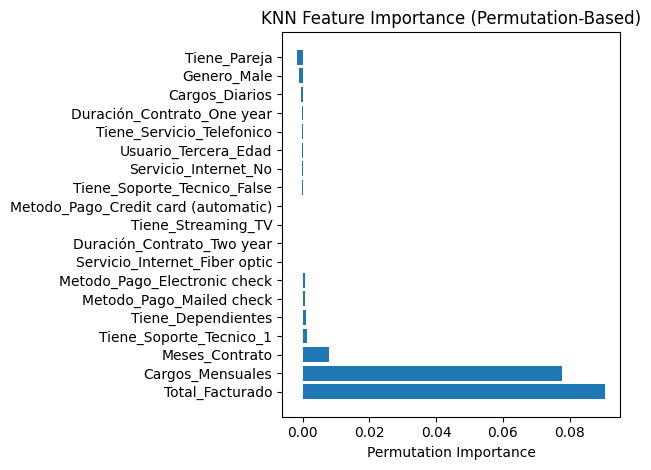

In [53]:
# Assuming you have a trained KNN model or pipeline
result = permutation_importance(knn_model, X_test, y_test, n_repeats=10, random_state=42)

# Display

sorted_idx = result.importances_mean.argsort()[::-1]
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_test.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("KNN Feature Importance (Permutation-Based)")
plt.tight_layout()
plt.show()

## Modelo de arbol de decisión

In [174]:
# Create the model
rf_model = RandomForestClassifier(
    n_estimators=150,       # number of trees in the forest
    max_depth=6,         # you can tune this later
    random_state=42         # reproducibility
)

# Fit on the training data
rf_model.fit(X_train_fold, y_train_fold)
# Predict on test data
y_pred_rf = rf_model.predict(X_test_fold)

In [175]:
# Accuracy
print(f'Accuracy: {accuracy_score(y_test_fold, y_pred_rf):.4f}')

# Classification report
print("Classification Report:")
print(classification_report(y_test_fold, y_pred_rf))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_fold, y_pred_rf))

Accuracy: 0.8094
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1086
           1       0.70      0.44      0.54       367

    accuracy                           0.81      1453
   macro avg       0.76      0.69      0.71      1453
weighted avg       0.80      0.81      0.79      1453

Confusion Matrix:
[[1016   70]
 [ 207  160]]


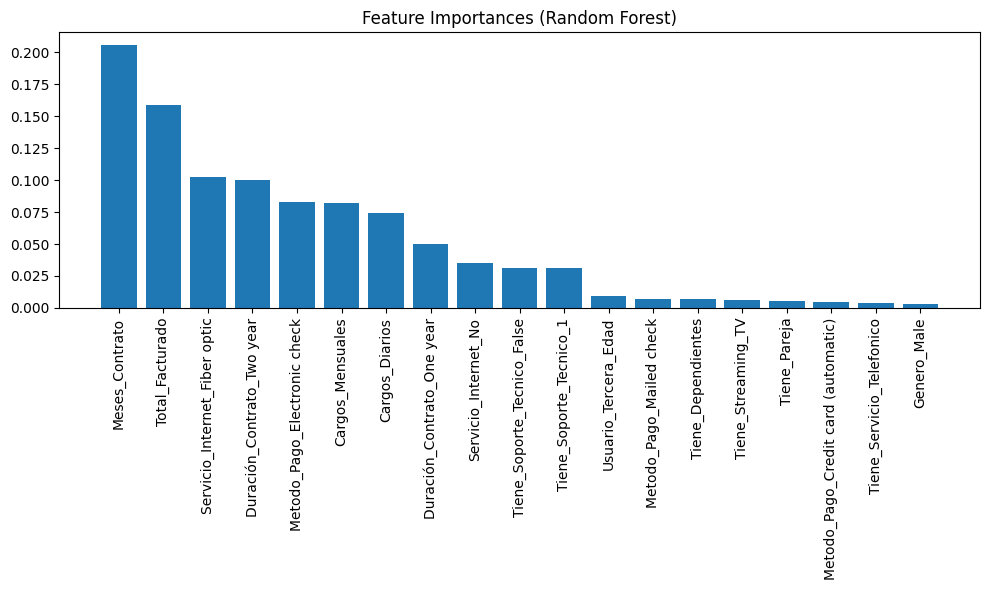

In [177]:
# Feature importances
importances = rf_model.feature_importances_
feature_names = X_train_fold.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()